In [2]:
from source import create_db, create_df, heatmap, pieplot, barcharts, histograms, scatterplots
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
import os

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif, RFECV, RFE
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV, LinearRegression, LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import numpy as np



pd.set_option("display.max_columns", None)

In [2]:
query = "SELECT * FROM df"
query_2 = "PRAGMA table_info(df)"
df = create_df(query, index=True)
df_info = create_df(query_2)

# EDA

## Informacion de Variables en el DataFrame

In [ ]:
df_info

## Comparacion de datos por año

### Proporcion de bajas en la empresa por año

In [ ]:
pieplot(df)

### Coparacion de la distribucion de los datos por año

#### 2015

Numero de columna: 0


0


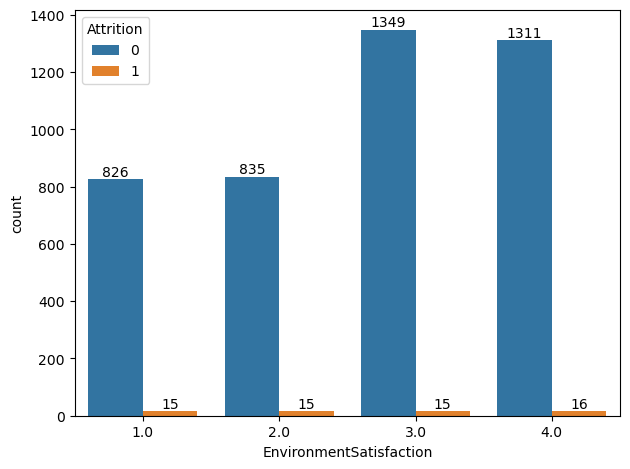

In [49]:
list_cat = df.select_dtypes("object").drop(columns="Attrition").columns
col = eval(input("Numero de columna:", ))
barcharts(df=df[df["Date"].dt.strftime("%Y") == "2015"], normalize=False, only=True, targ_col=list_cat[col])
print(col)

#### 2016

In [ ]:
list_cat = df.select_dtypes("object").drop(columns="Attrition").columns
col = eval(input("Numero de columna:", ))
barcharts(df=df[df["Date"].dt.strftime("%Y") == "2016"], normalize=False, only=True, targ_col=list_cat[col])
print(col)

## Mapa de Correlacion

In [ ]:
heatmap(df, annot=True)

## Mapas de Dispersion

In [ ]:
scatterplots(df)

## Histogramas Variables Numericas

In [ ]:
histograms(df)

## Diagramas de barra Variables Categoricas

In [ ]:
barcharts(df)

# Seleccion de Variables

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif, RFECV, RFE
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV, LinearRegression, LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, f1_score

In [4]:
query = "SELECT * FROM df"
df = create_df(query, index=True)

target = "Attrition"

X = df.drop([target, "retirementType", "resignationReason", "Date"], axis=1)
y = df[target]

# X["Date"] = X["Date"].dt.strftime("%Y").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_processor = OrdinalEncoder()
num_processor = MinMaxScaler()

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

vars = {"chi2":[], "mutual_info":[]}

for m in (chi2, mutual_info_classif):
  for k in range(5, 25):

    selector = make_pipeline(processor,
                          SelectKBest(m, k=k))

    selector.fit(X_train, y_train)
    if m == chi2:
      vars["chi2"] += selector.get_feature_names_out().tolist()
    else:
      vars["mutual_info"] += selector.get_feature_names_out().tolist()



vars_kb = pd.DataFrame({i:pd.Series(j).value_counts() for i,j in vars.items()})

vars_kb.index = vars_kb.index.str[5:]

SyntaxError: invalid syntax (288945800.py, line 3)

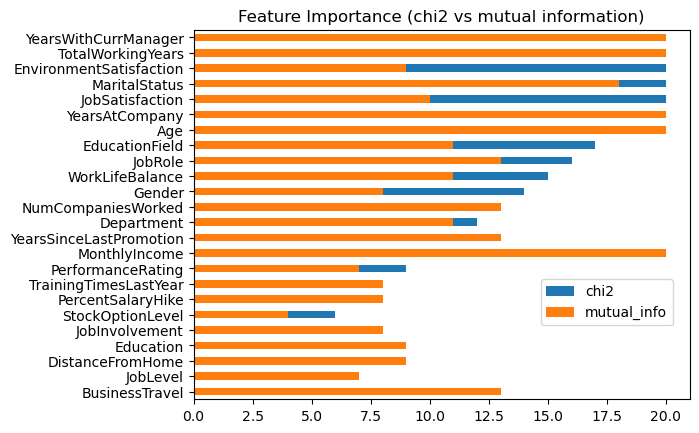

In [5]:
vars_kb.sort_values(by="chi2", ascending=True).plot(kind="barh", subplots=[("chi2", "mutual_info")])
plt.legend(loc=[0.7, 0.2])
plt.title("Feature Importance (chi2 vs mutual information)");

In [6]:
num_feat = 20
num_rfe = 15
metric = ["chi2", "mutual_info"]


criterion = ["gini", "entropy", "log_loss"]


vars_rfe = pd.DataFrame()

for m in metric:

  target = "Attrition"

  X = df[vars_kb[m].sort_values(ascending=False).index.values.tolist()[:num_feat]]
  y = df[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  cat_processor = OrdinalEncoder()
  num_processor = MinMaxScaler()

  num_vals = X._get_numeric_data().columns.tolist()
  cat_vals = X.select_dtypes("object").columns.tolist()

  processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

  for c in criterion:



    selector = make_pipeline(processor,
                            RFE(DecisionTreeClassifier(criterion=c, random_state=42), n_features_to_select=num_rfe))

    selector.fit(X_train, y_train)

    X.columns[selector.named_steps["rfe"].support_].values.tolist()

    vars_rfe[c+f"_{m}"] = X.columns[selector.named_steps["rfe"].support_].values


vars_rfe

,gini_chi2,entropy_chi2,log_loss_chi2,gini_mutual_info,entropy_mutual_info,log_loss_mutual_info
0,YearsWithCurrManager,YearsWithCurrManager,YearsWithCurrManager,YearsWithCurrManager,YearsAtCompany,YearsAtCompany
1,EnvironmentSatisfaction,EnvironmentSatisfaction,EnvironmentSatisfaction,YearsAtCompany,TotalWorkingYears,TotalWorkingYears
2,TotalWorkingYears,TotalWorkingYears,TotalWorkingYears,MonthlyIncome,MaritalStatus,MaritalStatus
3,MaritalStatus,MaritalStatus,MaritalStatus,Age,YearsSinceLastPromotion,YearsSinceLastPromotion
4,JobSatisfaction,JobSatisfaction,JobSatisfaction,MaritalStatus,NumCompaniesWorked,NumCompaniesWorked
5,YearsAtCompany,EducationField,EducationField,NumCompaniesWorked,BusinessTravel,BusinessTravel
6,WorkLifeBalance,NumCompaniesWorked,NumCompaniesWorked,BusinessTravel,WorkLifeBalance,WorkLifeBalance
7,NumCompaniesWorked,Department,Department,EducationField,EducationField,EducationField
8,Department,YearsSinceLastPromotion,YearsSinceLastPromotion,JobSatisfaction,JobSatisfaction,JobSatisfaction
9,YearsSinceLastPromotion,MonthlyIncome,MonthlyIncome,DistanceFromHome,DistanceFromHome,DistanceFromHome


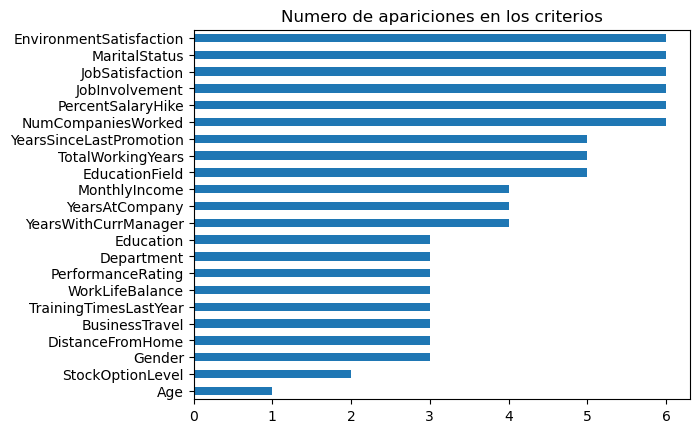

In [7]:
from collections import Counter

counter = Counter()

for i in vars_rfe.columns:
  counter.update(vars_rfe[i])

n_select = pd.DataFrame(counter.values(), index=counter.keys()).rename(columns={0:"count"}).sort_values(by="count", ascending=True)

n_select.plot(kind="barh", title="Numero de apariciones en los criterios", legend=False);

In [49]:
threshold = 0.1
target = "Attrition"

X = df[vars_df["mutual_info"].sort_values(ascending=False).index.tolist()[:10]]
y = df[target]

# X["Date"] = X["Date"].dt.strftime("%Y").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_processor = OrdinalEncoder()
num_processor = MinMaxScaler()

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

alphas = np.arange(0.1, 10, 1.5)
criterions = {"gini", "entropy", "log_loss"}
selector = make_pipeline(processor, 
                         SelectFromModel(DecisionTreeClassifier(criterion="entropy", random_state=42), threshold=0.06))

selector.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['MaritalStatus',
                                                   'JobSatisfaction',
                                                   'BusinessTravel']),
                                                 ('num', MinMaxScaler(),
                                                  ['YearsAtCompany',
                                                   'TotalWorkingYears',
                                                   'MonthlyIncome', 'Age',
                                                   'YearsWithCurrManager',
                                                   'NumCompaniesWorked',
                                                   'YearsSinceLastPromotion'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                  random_state=42),
                                 threshold=0.06))])

In [50]:
selector.get_feature_names_out()

array(['cat__JobSatisfaction', 'num__YearsAtCompany',
       'num__TotalWorkingYears', 'num__MonthlyIncome', 'num__Age',
       'num__YearsWithCurrManager', 'num__NumCompaniesWorked',
       'num__YearsSinceLastPromotion'], dtype=object)

In [30]:
query = "SELECT * FROM df"
df = create_df(query, index=True)

threshold = 0.1
target = "Attrition"

X = df.drop([target, "retirementType", "resignationReason", "Date"], axis=1)y = df[target]

# X["Date"] = X["Date"].dt.strftime("%Y").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_processor = OneHotEncoder()
num_processor = MinMaxScaler()

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

alphas = np.arange(0.1, 10, 1.5)

selector = make_pipeline(processor, 
                         SelectFromModel(LassoCV(alphas=alphas, cv=5, ), threshold=0.01))

selector.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance',
                                                   'BusinessTravel',
                                                   'Department', 'Education',
                                                   'EducationField', 'Gender',
                                                   'JobLevel', 'JobRole',
                                                   'MaritalStatus',
                                                   'StockOptionLevel',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'retirementType',
                                                   'resignationReason']),
                                                 ('num', MinMaxScaler(),
                                                  ['Date', 'Age',
                                                   'DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=LassoCV(alphas=array([0.1, 1.6, 3.1, 4.6, 6.1, 7.6, 9.1]),
                                                   cv=5),
                                 threshold=0.01))])

In [31]:
selector.get_feature_names_out()

array([], dtype=object)

In [ ]:
selector.named_steps["variancethreshold"].get_feature_names_out().shape

In [ ]:
selector = VarianceThreshold(threshold=threshold)
X_temp = X[cat_vals]

# selector.fit(X_temp)

X_temp.shape

In [ ]:
selector.get_feature_names_out()

# Modelos

In [ ]:
query = "SELECT * FROM df"
df = create_df(query, index=True)

vars = n_select.index.values
target = "Attrition"

# X = df.drop([target, "retirementType", "resignationReason", "Date"], axis=1)
X = df[vars]

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_processor = OrdinalEncoder()
num_processor = MinMaxScaler()

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

model = make_pipeline(processor,
                      GradientBoostingClassifier(random_state=42))


model.fit(X_train, y_train)

In [9]:
query = "SELECT * FROM df"
df = create_df(query, index=True)

# vars = vars_rfe["gini_chi2"]

target = "Attrition"

X = df.drop([target, "retirementType", "resignationReason", "Date"], axis=1)

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

over_sampler = RandomOverSampler(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)


X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

cat_processor = OrdinalEncoder()
num_processor = StandardScaler()

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

model = make_pipeline(processor,
                      RandomForestClassifier(random_state=42))


model.fit(X_train, y_train)

NameError: name 'RandomOverSampler' is not defined

In [8]:
model.score(X_test, y_test)

NameError: name 'model' is not defined

In [ ]:
silhouette_scores = []
inertia_errors = []

query = "SELECT * FROM df"
        
df = create_df(query, index=True)

target = "Attrition"

X = df[features]
y = df[target]

for n_clusters in range(2, 10):

    

    num_vals = X._get_numeric_data().columns.tolist()
    cat_vals = X.select_dtypes("object").columns.tolist()
    
    
        
    cat_processor = OneHotEncoder()
    num_processor = StandardScaler()

    processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

    model = make_pipeline(processor, 
                     KMeans(n_clusters=n_clusters, random_state=42))
    model.fit(X)

    silhouette_scores.append(silhouette_score(processor.fit_transform(X), model.named_steps["kmeans"].labels_))

    inertia_errors.append(model.named_steps["kmeans"].inertia_)


silhouette_serie = pd.Series(silhouette_scores, index=range(2, 10))
inertia_serie = pd.Series(inertia_errors, index=range(2, 10))


In [ ]:
model.score(X_test, y_test)

In [ ]:


query = "SELECT * FROM df"
df = create_df(query, index=True)

vars = vars_rfe["gini_chi2"]

target = "Attrition"

X = df[vars]
# X = df.drop([target, "retirementType", "resignationReason", "Date"], axis=1)

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_processor = OneHotEncoder()
num_processor = StandardScaler()

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

model = make_pipeline(processor,
                      SVC(random_state=42))


model.fit(X_train, y_train)

In [ ]:
plt.subplot(2,1,1)
silhouette_serie.plot(kind="line", ylabel="Silhouette Score", xlabel="N clusters")
plt.subplot(2,1,2)
inertia_serie.plot(kind="line", ylabel="Inertia", xlabel="N clusters")

plt.tight_layout()


In [ ]:
n_clusters = 4

query = "SELECT * FROM df"
        
df = create_df(query, index=True)

target = "Attrition"

X = df[features]
y = df[target]

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()


    
cat_processor = OneHotEncoder()
num_processor = StandardScaler()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

model = make_pipeline(processor, 
                     KMeans(n_clusters=n_clusters, random_state=42))

model.fit(X)

In [ ]:
labels = model.named_steps["kmeans"].labels_

In [ ]:
query = "SELECT * FROM df"
df = create_df(query, index=True)

df["Labels"] = labels

df = df[df["Date"].dt.strftime("%Y") == "2016"]

In [ ]:
num_vals = df._get_numeric_data().drop("Labels", axis=1).columns.tolist()
cat_vals = df.select_dtypes("object").columns.tolist()

xgb = df.groupby(["Labels"], as_index=True)[num_vals].mean()

xgb

scaler = StandardScaler()

xgb_scal = pd.DataFrame(scaler.fit_transform(xgb), columns=xgb.columns, index=xgb.index)

In [ ]:
import plotly.express as px
fig = px.bar(xgb_scal.T.abs(), barmode="group", labels={"Labels":"<b>Cluster</b>"}, 
             template="plotly_white", color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title="<b>Feature</b>", yaxis_title="<b>Normalized median</b>")

fig.show()

In [ ]:
xgb = df.groupby("Labels", as_index=False)["retirementType"].value_counts(normalize=True)
xgb

In [ ]:
fig = px.bar(xgb, x="retirementType", y="proportion", color=xgb["Labels"].astype(str), barmode="group", labels={"Labels":"<b>Cluster</b>"}, 
             template="plotly_white", color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title="<b>Feature</b>", yaxis_title="<b>Normalized median</b>")

fig.show()

In [ ]:
xgb = df.groupby("Labels", as_index=False)["Department"].value_counts(normalize=True)

In [ ]:
fig = px.bar(xgb, x="Department", y="proportion", color=xgb["Labels"].astype(str), barmode="group", labels={"Labels":"<b>Cluster</b>"}, 
             template="plotly_white", color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title="<b>Feature</b>", yaxis_title="<b>Normalized median</b>")

fig.show()